### Exercicio 1 - Inteligencia Artificial



##### Adicionando dependencias e importações

In [40]:
import pandas as pd
import re
import requests 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from requests.packages.urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)


#### Coletando dados

In [41]:

column_names = [
    "Campus",
    "Ano de Ingresso",
    "Período Letivo",
    "Curso",
    "Modalidade",
    "Presencial/Distância",
    "Sexo",
    "Nível",
    "Renda per Capita",
    "Etnia",
    "Ano de Nascimento",
    "Situação"
]

column_types = {
    "Campus": "object",
    "Ano de Ingresso": "int64",
    "Período Letivo": "int64",
    "Curso": "object",
    "Modalidade": "object",
    "Presencial/Distância": "object",
    "Sexo": "object",
    "Nível": "object",
    "Renda per Capita": "object",
    "Etnia": "object",
    "Ano de Nascimento": "int64",
    "Situação": "object"
}

url = "https://barramento.ifg.edu.br/ifg_barramento_ws/ws/252"

try:
    response = requests.get(url, verify=False)
    response.raise_for_status()

    data = response.json()

    processed_data = []
    for item in data:
        row = [sub_item["valor"] for sub_item in item["itens"]]
        processed_data.append(row)

    df = pd.DataFrame(processed_data, columns=column_names)

    for column, col_type in column_types.items():
        if col_type == "int64":
            df[column] = pd.to_numeric(df[column], errors='coerce', downcast='integer')
        elif col_type == "float64":
            df[column] = pd.to_numeric(df[column], errors='coerce', downcast='float')
        elif col_type == "object":
            df[column] = df[column].astype(str)
    
    df.to_csv('./data/data.csv', index=False)

except requests.exceptions.RequestException as e:
    print(f"Erro na requisição: {e}")
except ValueError as e:
    print(f"Erro ao processar os dados: {e}")

#### Convertendo o valor da renda per capita para numérico

In [42]:
def convert_renda_per_capita(value):
    if isinstance(value, str):
        match = re.match(r"(\d+,\d+|\d+) Sm < Rfp <= (\d+,\d+|\d+) Sm", value)
        if match:
            lower_bound = float(match.group(1).replace(",", "."))
            upper_bound = float(match.group(2).replace(",", "."))
            return (lower_bound + upper_bound) / 2
    return np.nan

df["Renda per Capita"] = df["Renda per Capita"].apply(convert_renda_per_capita)

#### Pré-processando os dados

In [43]:
def pre_process(df):
    for coluna in df.columns:
        if df[coluna].dtype in ["float64", "int64"]:  
            df[coluna] = df[coluna].fillna(df[coluna].mean())  
        elif df[coluna].dtype == "object":
            if df[coluna].nunique() == 2:
                valores = df[coluna].unique()
                df[coluna] = df[coluna].map({valores[0]: 0, valores[1]: 1}).fillna(df[coluna])
            else:
                df[coluna] = df[coluna].fillna("Desconhecido")
    
    return df

df = pre_process(df)
df.to_csv('./data/processed_data.csv', index=False)



#### Tratando outliers

In [44]:
def remove_outliers(df):
    isolation_forest = IsolationForest(contamination=0.05)  

    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df_numeric = df[numeric_columns]
    
    outliers = isolation_forest.fit_predict(df_numeric)

    df_cleaned = df[outliers == 1]
    
    return df_cleaned

df = remove_outliers(df)
df.to_csv('./data/cleaned_data.csv',index=False)


#### Pós-processamento e transformação

In [45]:
def onehotencoder(df, colunas_categoricas):
    
    encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")  
    
    encoded_arrays = encoder.fit_transform(df[colunas_categoricas])
    
    encoded_df = pd.DataFrame(
        encoded_arrays,
        columns=encoder.get_feature_names_out(colunas_categoricas),
        index=df.index
    )
    
    df = df.drop(columns=colunas_categoricas)
    df = pd.concat([df, encoded_df], axis=1)
    
    return df

colunas_categoricas = ["Sexo","Campus","Curso","Modalidade","Presencial/Distância","Nível","Etnia","Situação"]
df = onehotencoder(df, colunas_categoricas)
df.to_csv('./data/encoded_data.csv', index=False)

#### Aplicação de modelos de regressão

In [54]:
from sklearn.linear_model import Ridge


X = df.drop(columns=["Renda per Capita"])
y = df["Renda per Capita"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    'alpha': [0.01, 0.1, 1, 10], 
    'l1_ratio': [0.1, 0.5, 0.9]   
}

elasticnet_model = ElasticNet()

grid_search = GridSearchCV(elasticnet_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_

mse_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=kf, scoring='neg_mean_squared_error')
r2_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=kf, scoring='r2')

mse_scores = -mse_scores

mean_mse = np.mean(mse_scores)
mean_r2 = np.mean(r2_scores)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("\nAvaliação do Modelo")
print(f"MSE médio: {mean_mse:.2f}")
print(f"R2 médio: {mean_r2:.2f}")


Avaliação do Modelo
MSE médio: 0.14
R2 médio: 0.07


#### Plots e insights

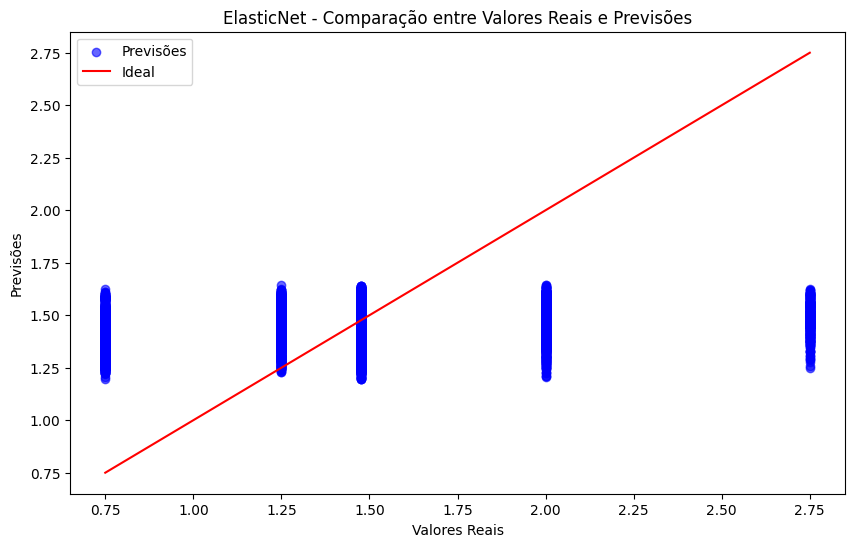

In [53]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, color="blue", label="Previsões", alpha=0.6)

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", label="Ideal")

plt.xlabel("Valores Reais")
plt.ylabel("Previsões")
plt.title("ElasticNet - Comparação entre Valores Reais e Previsões")

plt.legend()

plt.show()